# 8.7 RNN에 의한 문장의 자동 생성

리스트8.16 텍스트 데이터 읽어 들이기

In [23]:
from google.colab import drive

drive.mount('/content/drive/')

# Google 드라이브상의 텍스트 데이터로의 경로를 지정하세요
nov_path = '/content/drive/MyDrive/' + 'Colab Notebooks/AK_Colab/chapter_08/novels/은하철도의 밤.txt'

# 파일을 읽어 들인다
with open(nov_path, 'r') as f:
    nov_text = f.read()
    print(nov_text[:500])  # 첫 500문자만 표시

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
"그럼, 여러분은 이렇게 강이라고 하거나 우유가 흐른 흔적이라고 말하고 있는 이 희미하고 하얀 것이 실제로는 무엇인지 알고 있습니까?" 선생님은 칠판에 걸어 놓은 커다란 검은 별자리 지도의 위에서 아래쪽으로 희뿌연 띠 모양을 한 은하를 가리키며 모두에게 질문을 던졌습니다.
캄파넬라가 손을 들었습니다. 그리고 나서 네다섯 명이 손을 더 들었습니다. 조바니도 손을 들려고 하다가 황급히 그대로 멈추었습니다. 분명 그것이 모두 별이라고 언젠가 잡지에서 읽었지만, 요즘은 조바니는 교실에서도 졸고, 책을 읽을 틈도 읽을 책도 없기 때문에 왠지 아는 게 아무것도 없는 듯한 기분이 들었습니다.
그런데 선생님은 벌써 그것을 눈치챘습니다.
"조바니, 너는 알고 있겠지?"
조바니는 기세 좋게 일어났지만 막상 일어나보니 분명하게 대답할 수가 없었습니다. 자네리가 앞자리에서 뒤돌아보고 조바니를 보고 키득키득 웃었습니다. 조바니는 더 당황해서 얼굴이 새빨개졌습니다. 선생님이 또 말했습니다.
"큰 망원경으로 


리스트 8.17 정규 표현에 의한 전처리

In [ ]:
import re  # 정규표현에 필요한 라이브러리

text = re.sub("《[^》]+》", "", nov_text) # 루비의 삭제
text = re.sub("［[^］]+］", "", text) # 읽기 주의 삭제
text = re.sub("[｜ 　]", "", text) # | 과 반각 스페이스의 삭제
print("문자 수", len(text))  # len() 로 문자열의 문자 수도 취득 가능

문자 수 1721


리스트8.18 RNN의 각 설정

In [ ]:
n_rnn = 10  # 시계열의 수
batch_size = 128
epochs = 60
n_mid = 128  # 중간층의 뉴런 수

리스트8.19 문자의 벡터화

In [ ]:
import numpy as np

# 인덱스와 문자로 사전을 작성
chars = sorted(list(set(text)))  # set으로 문자의 중복을 없애고, 각 문자를 리스트에 저장한다
print("문자 수(중복 없음)", len(chars))
char_indices = {}  # 문자가 키로 인덱스가 값
for i, char in enumerate(chars):
    char_indices[char] = i
indices_char = {}  # 인덱스가 키로 문자가 값
for i, char in enumerate(chars):
    indices_char[i] = char

# 시계열로 늘어선 문자와 그 다음에 예측해야 할 문자를 꺼낸다
time_chars = []  # 시계열에 늘어선 문자
next_chars = []  # 예측해야 할 문자
for i in range(0, len(text) - n_rnn):
    time_chars.append(text[i: i + n_rnn])
    next_chars.append(text[i + n_rnn])

# 입력과 정답을 one-hot 표현으로 나타냅니다
x = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool_)  # 입력
t = np.zeros((len(time_chars), len(chars)), dtype=np.bool_)  # 정답
for i, t_cs in enumerate(time_chars):
    t[i, char_indices[next_chars[i]]] = 1  # 정답을 one-hot 표현으로 나타낸다
    for j, char in enumerate(t_cs):
        x[i, j, char_indices[char]] = 1  # 입력을 one-hot 표현으로 나타낸다
        
print("x의 형태", x.shape)
print("t의 형태", t.shape)

문자 수(중복 없음) 301
x의 형태 (1711, 10, 301)
t의 형태 (1711, 301)


리스트8.20 일반적인 RNN, LSTM, GRU 모델을 구축

In [ ]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, SimpleRNN, LSTM, GRU

# 일반적인 RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(n_mid, input_shape=(n_rnn, len(chars))))
model_rnn.add(Dense(len(chars), activation="softmax"))
model_rnn.compile(loss='categorical_crossentropy', optimizer="adam")
print(model_rnn.summary())

print()

# LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(n_mid, input_shape=(n_rnn, len(chars))))
model_lstm.add(Dense(len(chars), activation="softmax"))
model_lstm.compile(loss='categorical_crossentropy', optimizer="adam")
print(model_lstm.summary())

print()

# GRU
model_gru = Sequential()
model_gru.add(GRU(n_mid, input_shape=(n_rnn, len(chars))))
model_gru.add(Dense(len(chars), activation="softmax"))
model_gru.compile(loss='categorical_crossentropy', optimizer="adam")
print(model_gru.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               55040     
_________________________________________________________________
dense (Dense)                (None, 301)               38829     
Total params: 93,869
Trainable params: 93,869
Non-trainable params: 0
_________________________________________________________________
None

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               220160    
_________________________________________________________________
dense_1 (Dense)              (None, 301)               38829     
Total params: 258,989
Trainable params: 258,989
Non-trainable params: 0
_________________________________________________________________
None

Model: "sequ

리스트8.21 문장 생성용의 함수

In [ ]:
from tensorflow.python.keras.callbacks import LambdaCallback
 
def on_epoch_end(epoch, logs):
    print("에포크: ", epoch)

    beta = 5  # 확률 분포를 조정하는 상수
    prev_text = text[0:n_rnn]  # 입력에 사용하는 문자
    created_text = prev_text  # 생성되는 텍스트
    
    print("시드: ", created_text)

    for i in range(400):  # 400 문자를 생성한다
        # 입력을 one-hot 표현으로
        x_pred = np.zeros((1, n_rnn, len(chars)))
        for j, char in enumerate(prev_text):
            x_pred[0, j, char_indices[char]] = 1
        
        # 예측을 실시, 다음 문자를 얻는다
        y = model.predict(x_pred)
        p_power = y[0] ** beta  # 확률 분포의 조정
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))        
        next_char = indices_char[next_index]

        created_text += next_char
        prev_text = prev_text[1:] + next_char

    print(created_text)
    print()

# 에포크 종료 후에 실행할 함수를 설정
epock_end_callback= LambdaCallback(on_epoch_end=on_epoch_end)

리스트8.22 일반적인 RNN 모델의 학습

In [ ]:
# 일반적인 RNN
model = model_rnn
history_rnn = model_rnn.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

Epoch 1/60
14/14 [==============================] - 3s 13ms/step - loss: 5.6791
에포크:  0
시드:  "그럼,여러분은이렇
"그럼,여러분은이렇지게지으혀이않지라가얇라그히그라명라서는라그그축지세그의리그은그네을.를러지라라지내고그운게떠서이이색켰란없곧고이로지지지과기운더그세라이그라고희'도흐너라희림지엾미라러릴은이서않세그그지이물데,렇,게새이는그그게지알검라지황와는말새의게딜이라지고불도파구축서그그않이라라라그당게고고데그기그엇파게빛지만는빛되게라를않이이그데끄바게게게넬그흔않게욱라즈
거미'게물안지않미라형말파라라미게별경욱그짜게
그캄라,,공은않라켰게떠별게축공실쪽그를라얆그즈얆슷이그말라지캄닫지무게었일옆란하의망이거그라라희렌그언라이그그형게그그이이지도이그빛거습그게곧는엇희나
빛적멀그께지라은지망번틈게게그이세빛넬캄럼라말빨림문할이이갔이미거를고고않고라지라라라르진의았이그라라챘은라렌라켰게그이이그그라새이,이게게서그잠라그뜩지공지지파지라라게이이러라렌파은라않렌에럼면라그라지지이추많없께쌍라이말라이빛게고고거미였그

Epoch 2/60
14/14 [==============================] - 0s 14ms/step - loss: 5.2273
에포크:  1
시드:  "그럼,여러분은이렇
"그럼,여러분은이렇하이이이이이이.은지이고이이고고는이이고이.이이을이라이지이이이이이이이고하이고이이이는이이고이하이이이이이이이이에이에이이이이이이고그이을이이이이이이이고이이이이이이이이가이이가이고이이이이이이은그지이고이그이이이이이이이고이이이이이이이이이이이고이이이지이이이고이이하.이이이게이..이고게이는이이지이이고고이이고이이이이고는이고이파이이이게그고이이이이하이이고이고는이그이이을그이이하이이이이이이이이.이이이고이이고고이이이고이이지의이이이이이이고에이이이이고는이고이이이의고이라는이이이이이이이하이이이는이이이고이이고이이은이고고이이이고이고이이이하고이하이는게이이이이이이이이이그이하이이이이이그이고은이그이다이이이이이고이는그이이이고이이이이이고이이이이이이고이이고하이고서이이이이이이고이고이고고이이하라이이가이이고이그하그이

리스트8.23 LSTM 모델의 학습

In [ ]:
# LSTM
model = model_lstm
history_lstm = model_lstm.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

Epoch 1/60
14/14 [==============================] - 4s 67ms/step - loss: 5.6958
에포크:  0
시드:  "그럼,여러분은이렇
"그럼,여러분은이렇기처까체양곡멀닫혀즘판말깊멈합를반부잠습펴닥난형유강간겨검엇론슷물난속깊네고뿌로야크해록국냐느다간뜩늘에해득본멈곡집그스히단마밖반짝녁므노럼틈파냐므관답교흐실잘개래님수라채즘면트멈씩말리상슷외가건전갱각재교론도고씩네시?지트쪽향듯게님졌득굴제검얀까친즈니너림합즉깊학부칠더경놓고짜형기게비의밤기학쪽답은겁스판짝형능저인입므트.있답릴졌로갈원럼지견할미.님희언체떠손건보방점둘않볼런까못다엇쳤공인있을가트날네방책명마사여난뜩슷않너트정수갖분답갔즉반역자스작판인밖큰노카왠원우빛찰침안럼파녁트며함방각상부좋새며운언고았론뼛읽카지진젠보크카니득검던갖놓"태많겠막대님얗으일버그칠즉젠버읽말걸유었성놓으그저책래고번견처빼리께른기고으둘님양한끄고요얆없다인네위답얇미뿌갖모젠덕옆왠급을새틈켰한름두당엾한너넬았께놀위수럼모졌니이놓많나엾요래사노?버러처태써새세녁곧은번즉릴아쪽상물찰음노수약또잡슷사두슷지위되국소

Epoch 2/60
14/14 [==============================] - 1s 66ms/step - loss: 5.5861
에포크:  1
시드:  "그럼,여러분은이렇
"그럼,여러분은이렇.이.하.고는................고...........은.고.고....는..........바.은.........고.........는자...은....이....바고은이....는...
..이.은......은..그.보그...,이....다는...그.다.......고......다......는
.................고는고고....다........습...은.............리다..고고...고...은...그.고는.그.................
그.......고은...바고..바..로....고....
.....를.....께..고...은.........조모.습..리어....어..고고......이..
....고...................고.은고

리스트8.24 GRU 모델의 학습

In [ ]:
# GRU
model = model_gru
history_gru = model_gru.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

NameError: ignored


```
Epoch 51/60
303/303 [==============================] - 1s 4ms/step - loss: 0.3708
エポック:  50
シード:  「ではみなさんは、そ
「ではみなさんは、そうつにひりました。
そこらの白鳥もの方が見ると、あからこと云えました。
「あれようこんなんだかだって行って、くらっとしいからしやってはまん中にひろかにゆるくひと銀河ステーション、電気にはいっしょに、早く行ってそら、こっちの岸を、なからだまで何でしょう。」鳥捕りは、わかります。けれどもいつかごとあなるような、いっとこで合っていました。
「お父さんのきすろうかろが一時を出しくりに云っました。
「そうにはじさんで行くな。」ジョバンニが窓の外で云いました。
「もや、白い虫もなく。」
「そっちの居たね。」青年は男ま子がらの前の席に、青いやめているようござんはしい時間でした。こんなにのがあるでその黒い脚をつきました。
「ジョバンニ、その中はちらちら出てきれが何かそうっちへ引い込まれそうちに光ってそらそれを組み合せて、ジョバンニは思いました。
そして二人は、車の空のそらを見のからのに、たちして一つのつい
```

```
Epoch 53/60
303/303 [==============================] - 1s 4ms/step - loss: 0.3349
エポック:  52
シード:  「ではみなさんは、そ
「ではみなさんは、そう云う声もなく、赤いけれよ。頭をうししにいくさそしました。
「ぼくたちもちょっかりきのりしくらをたっていました。
「ああ、そうだ、今夜ケンタウル祭だねえ。」
「ああ、遠くからないよ。ぼくおり、さっきの河原中を、まったく立って、いろいろよろにからんながらゆるくくるの大きなにはもうしても少し遠くだろにびしおじぎをしてジョバンニは靴をぬいで上りますと、突き当りの大きな扉をあけました。中にはまだ昼なのに電燈がついてたくさんの輪転器がばたりばたりとまわり、きれで頭をしばったりラムプシェードをかけたりした人たちのたいといちめんのりこっかしはいまでいくようも見えら、あありました。
「ぼんたり、おっぺかにカムパネルラが、思わずもる支度をって下さい。けれども、誰かったかい。もジョバンニは、お辞儀をして台所から出ました。
「お母さん。今日は角砂糖を買ってきたよ。牛乳に入れてあげようと思って。」
「ああ、あのこ
```

```
Epoch 60/60
303/303 [==============================] - 1s 4ms/step - loss: 0.2327
エポック:  59
シード:  「ではみなさんは、そ
「ではみなさんは、そうにうつさして下に。金剛石ヤ。」ジョバンニは、窓から顔を出してじきと叫んました。
青年は
「ジョバンニ、カムパネルラが居たしました。そのとき俄かに大きな音がして私たちは水に落ちもう渦に入ったと思いながらしらへせいの中にはしばらく置きたね、どんですよ。」
「ああ、ぼくならずジョバンニの方なくの見えらなしかけながそわなにわたカムパネルラが地図で二人も胸いっぱいに吹い込みて、ほんとうにしたい、立っているというように思いました。

ジョバンニはあなりの男の子が云いました。カムパネルラは、円い板のようになった地図を、しきりにぐるぐるまわして見ていました。まったくその中に、白くあらわされた天の川の左の岸に沿って一条の鉄道線路が、南へ南へとたどって行くのでした。そしてその地図の立派なことは、夜のようにまっ黒な盤の上に、一一の停車場や三角標、泉水や森が、青や橙や緑や、うつくしい光でちりばめられてありました

```


리스트8.25 학습의 추이를 표시

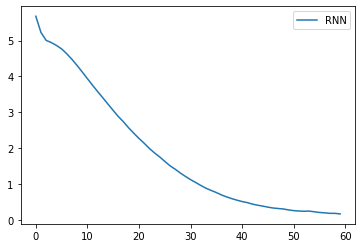

In [ ]:
import matplotlib.pyplot as plt

loss_rnn = history_rnn.history['loss']
#loss_lstm = history_lstm.history['loss']
#loss_gru = history_gru.history['loss']

plt.plot(np.arange(len(loss_rnn)), loss_rnn, label="RNN")
#plt.plot(np.arange(len(loss_lstm)), loss_lstm, label="LSTM")
#plt.plot(np.arange(len(loss_gru)), loss_gru, label="GRU")
plt.legend()
plt.show()